# Exercise 4

## Import packages

In [147]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [148]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    # use cuda if GPU is available
    if use_cuda:
        model.cuda()
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        network_output = model(data)
        
        # TODO: compute negative log likelihood loss
        loss = F.nll_loss(network_output, target)
        
        # TODO: do backpropagation
        loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if (batch_idx + 1) % log_interval == 0:
            print(f'Epoch [{epoch}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item()}')

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [149]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [150]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc_layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 100),
            nn.Sigmoid(),
            nn.Linear(100, 60),
            nn.Sigmoid(),
            nn.Linear(60, 30),
            nn.Sigmoid(),
            nn.Linear(30, 10)
        )

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 784)
        
        # TODO: run network layers
        x = self.fc_layers(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        
        return output

In [151]:
class FCNet2(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with Relu
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet2, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.ReLU(),
            nn.Linear(60, 30),
            nn.ReLU(),
            nn.Linear(30, 10)
        )

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc_layers(x)
        output = F.log_softmax(x, dim=1)
        return output

In [152]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.BatchNorm1d(60),
            nn.ReLU(),
            nn.Linear(60, 30),
            nn.ReLU(),
            nn.Linear(30, 10)
        )
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc_layers(x)
        output = F.log_softmax(x, dim=1)
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [153]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU()
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64*12*12, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv_layers(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64*12*12)
        
        # TODO: run fully connected layers
        x = self.fc_layers(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [154]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU()
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64*12*12, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 64*12*12)
        x = self.fc_layers(x)
        output = F.log_softmax(x, dim=1)
        return output

In [155]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64*12*12, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 64*12*12)
        x = self.fc_layers(x)
        output = F.log_softmax(x, dim=1)
        return output

Epoch [1], Step [100/938], Loss: 0.17405292391777039
Epoch [1], Step [200/938], Loss: 0.24961227178573608
Epoch [1], Step [300/938], Loss: 0.08315356820821762
Epoch [1], Step [400/938], Loss: 0.04111994430422783
Epoch [1], Step [500/938], Loss: 0.08621612191200256
Epoch [1], Step [600/938], Loss: 0.14415769279003143
Epoch [1], Step [700/938], Loss: 0.09311927109956741
Epoch [1], Step [800/938], Loss: 0.18958166241645813
Epoch [1], Step [900/938], Loss: 0.008422967977821827

Test set: Average loss: 0.0442, Accuracy: 9859/10000 (98.59%)



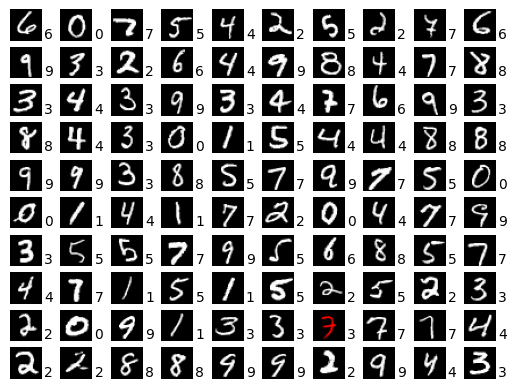

Epoch [2], Step [100/938], Loss: 0.042476363480091095
Epoch [2], Step [200/938], Loss: 0.005491402931511402
Epoch [2], Step [300/938], Loss: 0.008423053659498692
Epoch [2], Step [400/938], Loss: 0.01591230370104313
Epoch [2], Step [500/938], Loss: 0.10214401036500931
Epoch [2], Step [600/938], Loss: 0.001232474111020565
Epoch [2], Step [700/938], Loss: 0.07680512964725494
Epoch [2], Step [800/938], Loss: 0.022609034553170204
Epoch [2], Step [900/938], Loss: 0.039809390902519226

Test set: Average loss: 0.0314, Accuracy: 9894/10000 (98.94%)



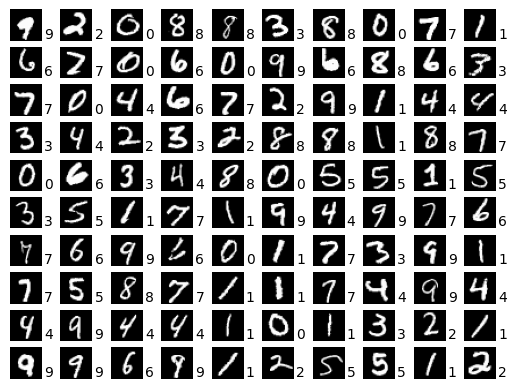

Epoch [3], Step [100/938], Loss: 0.02098282240331173
Epoch [3], Step [200/938], Loss: 0.013492699712514877
Epoch [3], Step [300/938], Loss: 0.0007967191631905735
Epoch [3], Step [400/938], Loss: 0.010158590041100979
Epoch [3], Step [500/938], Loss: 0.008233139291405678
Epoch [3], Step [600/938], Loss: 0.0024642297066748142
Epoch [3], Step [700/938], Loss: 0.002146465005353093
Epoch [3], Step [800/938], Loss: 0.001874475390650332
Epoch [3], Step [900/938], Loss: 0.008229648694396019

Test set: Average loss: 0.0263, Accuracy: 9913/10000 (99.13%)



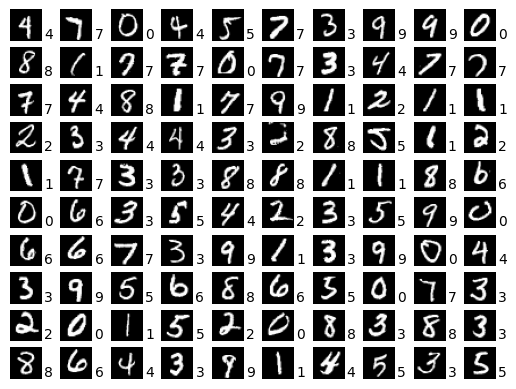

Epoch [4], Step [100/938], Loss: 0.019230665639042854
Epoch [4], Step [200/938], Loss: 0.0024123964831233025
Epoch [4], Step [300/938], Loss: 0.0010393671691417694
Epoch [4], Step [400/938], Loss: 0.00109644525218755
Epoch [4], Step [500/938], Loss: 0.0010048693511635065
Epoch [4], Step [600/938], Loss: 0.003988835494965315
Epoch [4], Step [700/938], Loss: 0.0012915299739688635
Epoch [4], Step [800/938], Loss: 0.006732311099767685
Epoch [4], Step [900/938], Loss: 0.021431177854537964

Test set: Average loss: 0.0268, Accuracy: 9915/10000 (99.15%)



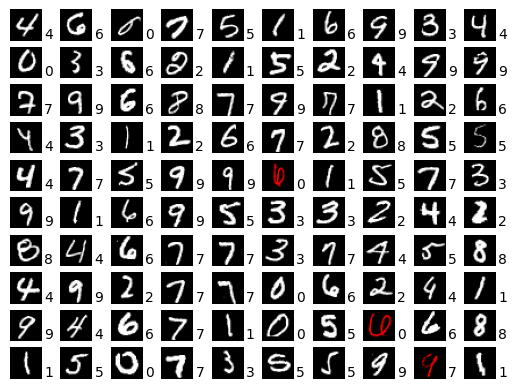

Epoch [5], Step [100/938], Loss: 0.004410319961607456
Epoch [5], Step [200/938], Loss: 0.0006788885220885277
Epoch [5], Step [300/938], Loss: 0.0020982208661735058
Epoch [5], Step [400/938], Loss: 0.0045849657617509365
Epoch [5], Step [500/938], Loss: 0.001391621888615191
Epoch [5], Step [600/938], Loss: 0.003354585962370038
Epoch [5], Step [700/938], Loss: 0.0005981178255751729
Epoch [5], Step [800/938], Loss: 0.0017894124612212181
Epoch [5], Step [900/938], Loss: 0.0005523834261111915

Test set: Average loss: 0.0266, Accuracy: 9908/10000 (99.08%)



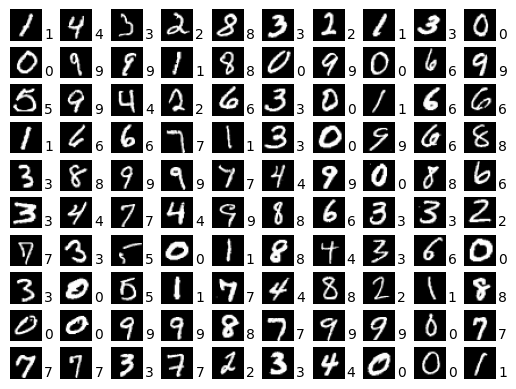

Epoch [6], Step [100/938], Loss: 0.00048567287740297616
Epoch [6], Step [200/938], Loss: 0.008344706147909164
Epoch [6], Step [300/938], Loss: 0.00017679510347079486
Epoch [6], Step [400/938], Loss: 0.0019165566191077232
Epoch [6], Step [500/938], Loss: 0.001038660411722958
Epoch [6], Step [600/938], Loss: 0.000850516080390662
Epoch [6], Step [700/938], Loss: 0.0008284510695375502
Epoch [6], Step [800/938], Loss: 0.0005084319855086505
Epoch [6], Step [900/938], Loss: 0.0006936975987628102

Test set: Average loss: 0.0273, Accuracy: 9913/10000 (99.13%)



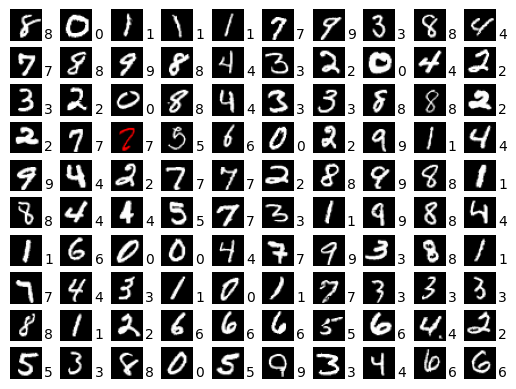

Epoch [7], Step [100/938], Loss: 0.0005313715082593262
Epoch [7], Step [200/938], Loss: 0.0005361833027563989
Epoch [7], Step [300/938], Loss: 0.0024516722187399864
Epoch [7], Step [400/938], Loss: 0.0005219111917540431
Epoch [7], Step [500/938], Loss: 0.0008157552219927311
Epoch [7], Step [600/938], Loss: 0.002707785926759243
Epoch [7], Step [700/938], Loss: 0.00772876339033246
Epoch [7], Step [800/938], Loss: 0.001058995840139687
Epoch [7], Step [900/938], Loss: 0.001295427093282342

Test set: Average loss: 0.0283, Accuracy: 9915/10000 (99.15%)



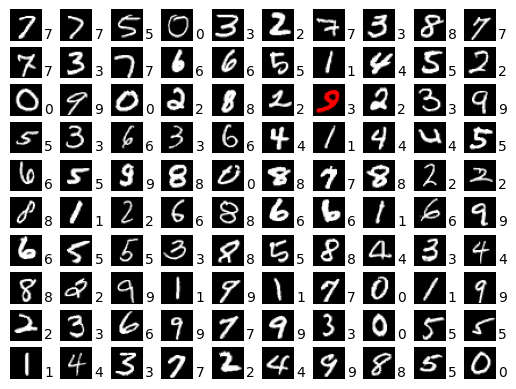

Epoch [8], Step [100/938], Loss: 0.002115995390340686
Epoch [8], Step [200/938], Loss: 0.00012262992095202208
Epoch [8], Step [300/938], Loss: 0.005042084958404303
Epoch [8], Step [400/938], Loss: 0.001657006680034101
Epoch [8], Step [500/938], Loss: 0.0002012536278925836
Epoch [8], Step [600/938], Loss: 0.004300803877413273
Epoch [8], Step [700/938], Loss: 0.0015790242468938231
Epoch [8], Step [800/938], Loss: 0.0007327658822759986
Epoch [8], Step [900/938], Loss: 0.0003264480037614703

Test set: Average loss: 0.0265, Accuracy: 9911/10000 (99.11%)



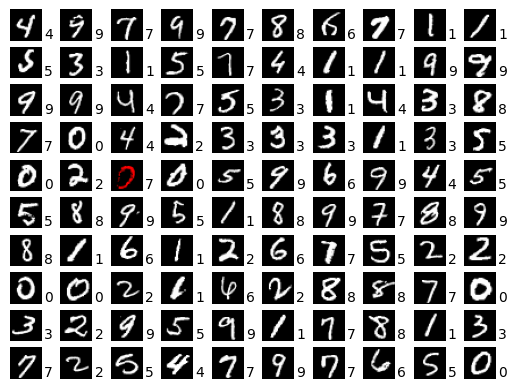

Epoch [9], Step [100/938], Loss: 0.011240553110837936
Epoch [9], Step [200/938], Loss: 0.0007979328511282802
Epoch [9], Step [300/938], Loss: 0.00010105250839842483
Epoch [9], Step [400/938], Loss: 0.0030680010095238686
Epoch [9], Step [500/938], Loss: 0.0009606402018107474
Epoch [9], Step [600/938], Loss: 0.0002662926563061774
Epoch [9], Step [700/938], Loss: 0.0010287074837833643
Epoch [9], Step [800/938], Loss: 0.0004934471799060702
Epoch [9], Step [900/938], Loss: 0.00023309007519856095

Test set: Average loss: 0.0268, Accuracy: 9916/10000 (99.16%)



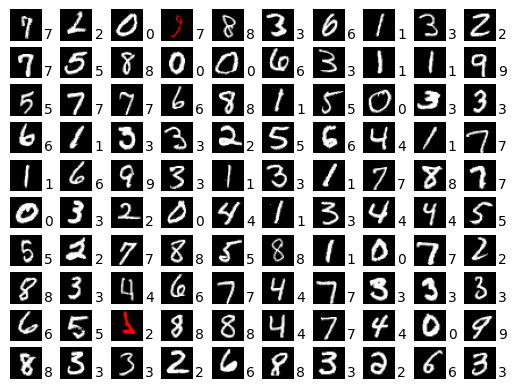

Epoch [10], Step [100/938], Loss: 0.007877064868807793
Epoch [10], Step [200/938], Loss: 0.0003503554908093065
Epoch [10], Step [300/938], Loss: 0.002668060129508376
Epoch [10], Step [400/938], Loss: 0.0007485711248591542
Epoch [10], Step [500/938], Loss: 0.0005136612453497946
Epoch [10], Step [600/938], Loss: 0.0007961412193253636
Epoch [10], Step [700/938], Loss: 0.00583578459918499
Epoch [10], Step [800/938], Loss: 0.0002205047057941556
Epoch [10], Step [900/938], Loss: 0.00011370285938028246

Test set: Average loss: 0.0268, Accuracy: 9910/10000 (99.10%)



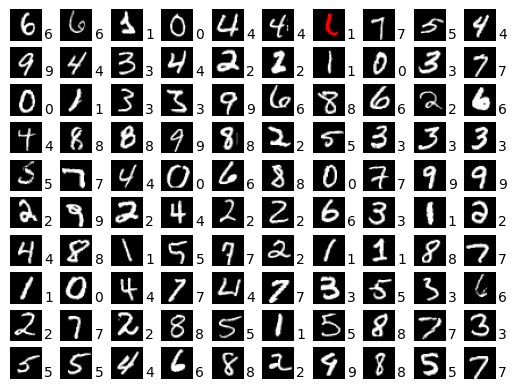

In [156]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = ConvNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")